In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import glob, os, warnings, pickle

import cv2

warnings.filterwarnings('ignore')

### Top categories

In [2]:
df_styles = pd.read_csv("../Data/styles.csv", error_bad_lines = False)

'''
    Use the following code-line to read data
    ## df_stratified_top = pickle.load(open("../Data/stratified_data.p", 'rb')) ##
'''

df_stratified_top = pickle.load(open("../Data/stratified_data.p", 'rb'))

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

In [ ]:
df_styles.head()

In [ ]:
top_n = 5
top_n_list = list(df_styles.groupby(['subCategory', 'articleType'])['id'].agg({'count'}).nlargest(columns = 'count', n = top_n).reset_index()['articleType'])

In [ ]:
top_n_list

In [ ]:
df_top_n = df_styles[
    df_styles['articleType'].isin(top_n_list)
]

In [ ]:
df_stratified_top = df_top_n.groupby('articleType', group_keys=False).apply(lambda x: x.sample(min(len(x), 1000))).reset_index(drop = True)

In [ ]:
pickle.dump(df_stratified_top, open("../Data/stratified_data.p", 'wb'))

### Structuring the image dataset

In [3]:
import shutil

from sklearn.model_selection import train_test_split

In [4]:
df_stratified_top['articleType'] = df_stratified_top['articleType'].astype('category')
df_stratified_top['label'] = df_stratified_top['articleType'].cat.codes
df_stratified_top.head()
df_stratified_sliced = df_stratified_top.loc[:, ['id', 'label']]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    df_stratified_sliced['id'], 
    df_stratified_sliced['label'], 
    test_size = 0.3, 
    random_state = 1769
)

In [ ]:
folder_path = "../Data/images"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

folder_path = "..//Data//images//{}//"

if not os.path.exists(folder_path.format('train')):
    os.makedirs(folder_path.format('train'))
    
if not os.path.exists(folder_path.format('test')):
    os.makedirs(folder_path.format('test'))

sub_folder_path = folder_path.format('train') + '{}'
for i in y_train.unique():
    if not os.path.exists(sub_folder_path.format(str(i))):
        os.makedirs(sub_folder_path.format(str(i)))
        
sub_folder_path = folder_path.format('test') + '{}'
for i in y_test.unique():
    if not os.path.exists(sub_folder_path.format(str(i))):
        os.makedirs(sub_folder_path.format(str(i)))

In [ ]:
train_path = "..//Data//images//train//{}//{}.jpg"
source_path = "D://Data//fashion-product-images-dataset//fashion-dataset//fashion-dataset//images//{}.jpg"

print ("Structuring TRAIN dataset")
i = 0
for idx, label in zip(X_train, y_train):
    i += 1
    print (i)
    file_path_to_store = train_path.format(str(label), str(idx))
    shutil.copyfile(
        source_path.format(idx),
        file_path_to_store
    )

test_path = "..//Data//images//test//{}//{}.jpg"
print ("Structuring TEST dataset")
for idx, label in zip(X_test, y_test):
    i += 1
    print (i)
    file_path_to_store = test_path.format(str(label), str(idx))
    shutil.copyfile(
        source_path.format(idx),
        file_path_to_store
    )

### ImageDataGenerator

In [6]:
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dropout, Dense

from keras.optimizers import adam

Using TensorFlow backend.


In [10]:
BATCH_SIZE = 16

datagen = ImageDataGenerator(
    rotation_range = 90, 
    zoom_range = 0.2, 
    fill_mode = 'nearest', 
    horizontal_flip = True, 
    vertical_flip = True, 
#     rescale = 1./255, 
    data_format = 'channels_last', 
    dtype='float32'
)

# folder_path = '..//Data//images//{}/'
folder_path = 'D://Data//images//{}/'

train_it = datagen.flow_from_directory(
    folder_path.format('train'), 
    target_size = (1024, 768), 
    color_mode = 'rgb', 
    class_mode = 'categorical', 
    batch_size = BATCH_SIZE, 
    shuffle = True, 
    interpolation='nearest'
)

test_it = datagen.flow_from_directory(
    folder_path.format('test'), 
    target_size = (1024, 768), 
    color_mode = 'rgb', 
    class_mode = 'categorical', 
    batch_size = BATCH_SIZE, 
    shuffle = True, 
    interpolation='nearest'
)

Found 3500 images belonging to 5 classes.
Found 1500 images belonging to 5 classes.


In [11]:
model = Sequential()

model.add(Conv2D(16, (3, 3), input_shape = (1024, 768, 3), activation='relu', strides = 1, padding = 'same', name = 'input'))
model.add(MaxPool2D((3, 3), name = 'input_pool'))

model.add(Conv2D(32, (3, 3), activation='relu', strides = 1, padding = 'same', name = 'conv1'))
model.add(MaxPool2D((3, 3), name = 'pool1'))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu', strides = 1, padding = 'same', name = 'conv2'))
model.add(MaxPool2D((2, 2), name = 'pool2'))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu', strides = 1, padding = 'valid', name = 'conv3'))
model.add(MaxPool2D((2, 2), name = 'pool3'))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu', strides = 1, padding = 'valid', name = 'conv4'))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(1024, activation = 'relu', name = 'dense1'))
model.add(Dense(512, activation = 'relu', name = 'dense2'))
model.add(Dense(256, activation = 'relu', name = 'dense3'))
model.add(Dense(5, activation = 'relu', name = 'dense4'))

model.summary()

model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Conv2D)               (None, 1024, 768, 16)     448       
_________________________________________________________________
input_pool (MaxPooling2D)    (None, 341, 256, 16)      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 341, 256, 32)      4640      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 113, 85, 32)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 113, 85, 32)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 113, 85, 64)       18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 42, 64)       

In [12]:
model.fit_generator(
    generator = train_it,
    steps_per_epoch = train_it.samples // BATCH_SIZE,
    validation_data = test_it, 
    validation_steps = test_it.samples // BATCH_SIZE,
    epochs = 10
)

Epoch 1/10
218/218 [==============================] - 2720s 12s/step - loss: nan - accuracy: 0.2044 - val_loss: nan - val_accuracy: 0.1882
Epoch 2/10
218/218 [==============================] - 5235s 24s/step - loss: nan - accuracy: 0.2058 - val_loss: nan - val_accuracy: 0.1887
Epoch 3/10
119/218 [===============>..............] - ETA: 21:41 - loss: nan - accuracy: 0.2054

KeyboardInterrupt: 

In [3]:
# pickle.dump(model, open("../Data/local_model_v1.p", 'wb'))
model = pickle.load(open("../Data/local_model.p", 'rb'))

Using TensorFlow backend.


### Visualiazing Activation  Maps

- make the model back to size 256x256x3
- add checkpoints
- 

In [4]:
from keras.models import Model
from keras.preprocessing.image import load_img, img_to_array
from keras.utils.vis_utils import plot_model

In [6]:
layer_outputs = [layer.output for layer in model.layers[:12]] 

activation_model = Model(
    inputs = model.input, 
    outputs = layer_outputs
)

In [13]:
temp = load_img(
    "../../images/train/0/10142.jpg", 
    target_size = (256, 256, 3)
)

temp_arr = img_to_array(temp)
temp_arr = np.reshape(temp_arr, (1, 256, 256, 3))

activations = activation_model.predict(temp_arr) 

In [9]:
model.summary()
# plot_model(model, to_file='../Data/local_model_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 84, 84, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 82, 82, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 27, 27, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 27, 27, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 256)       295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 256)        

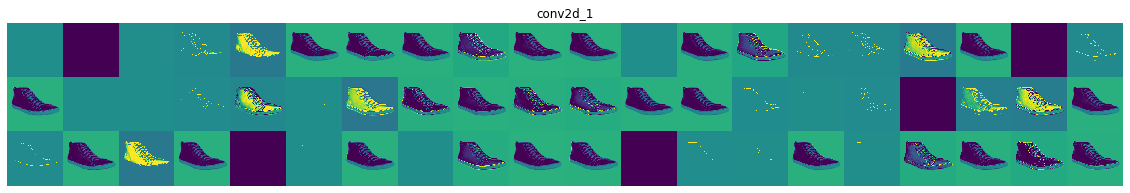

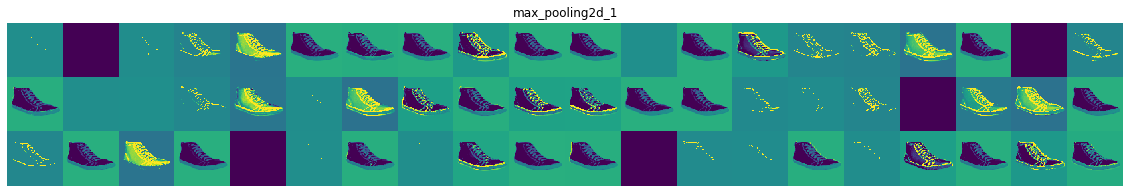

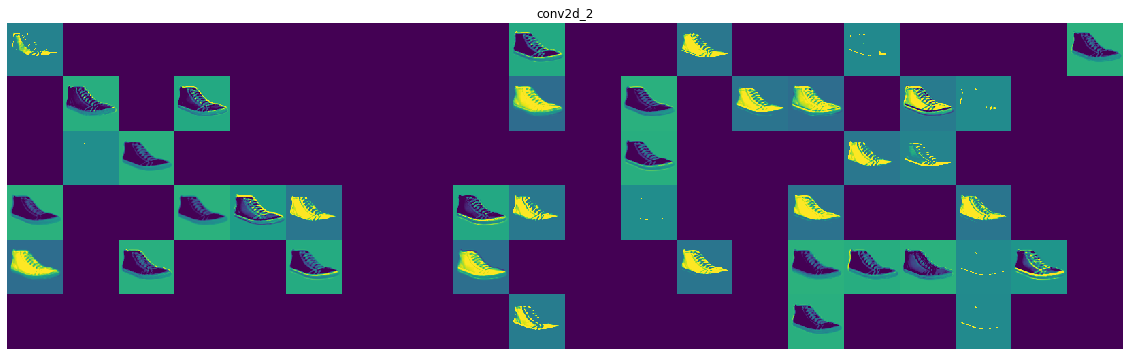

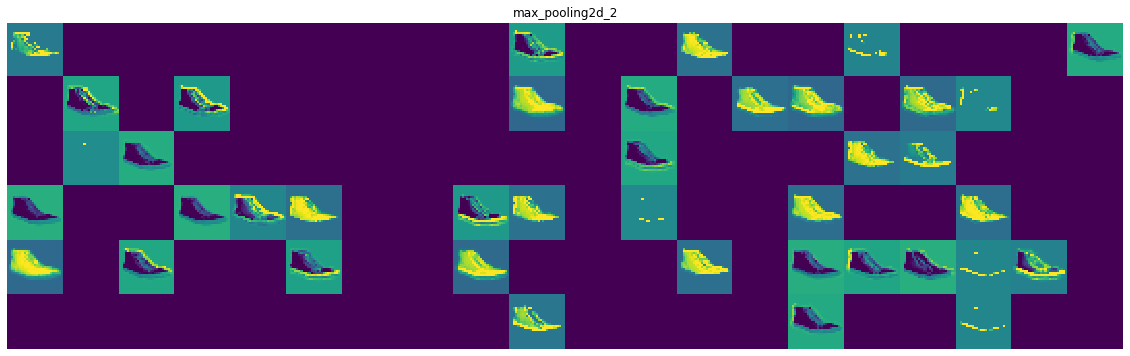

In [36]:
layer_names = []
for layer in model.layers[:4]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 20

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.axis('off')
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

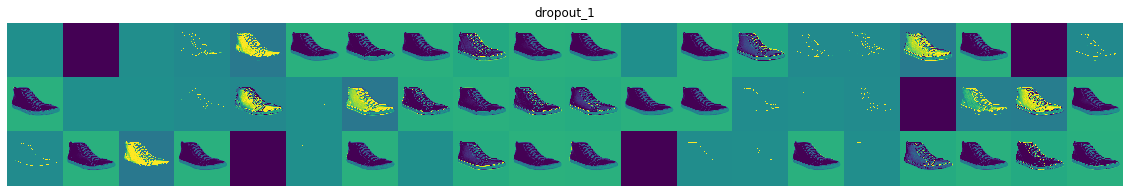

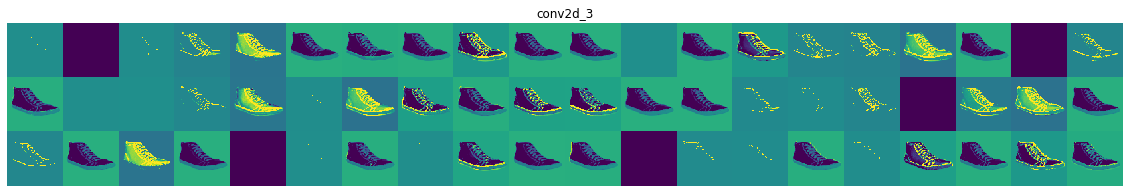

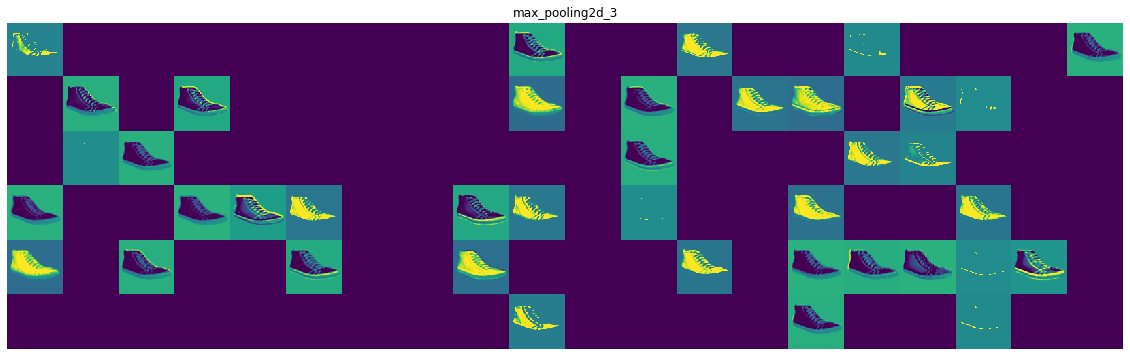

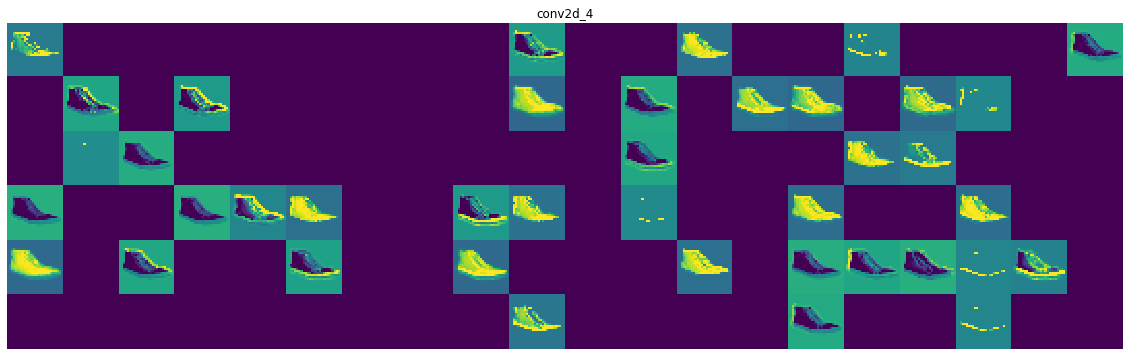

In [37]:
layer_names = []
for layer in model.layers[4:8]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 20

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.axis('off')
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

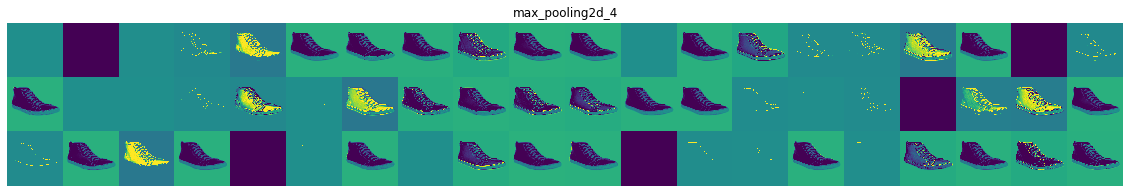

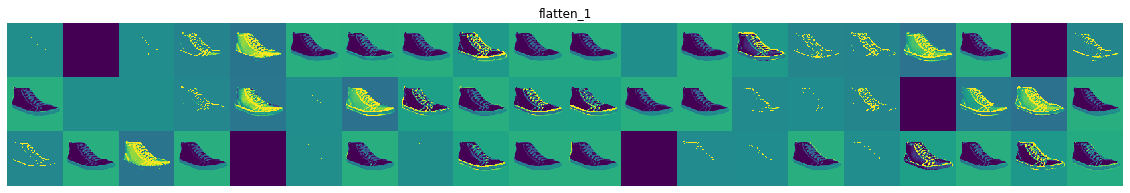

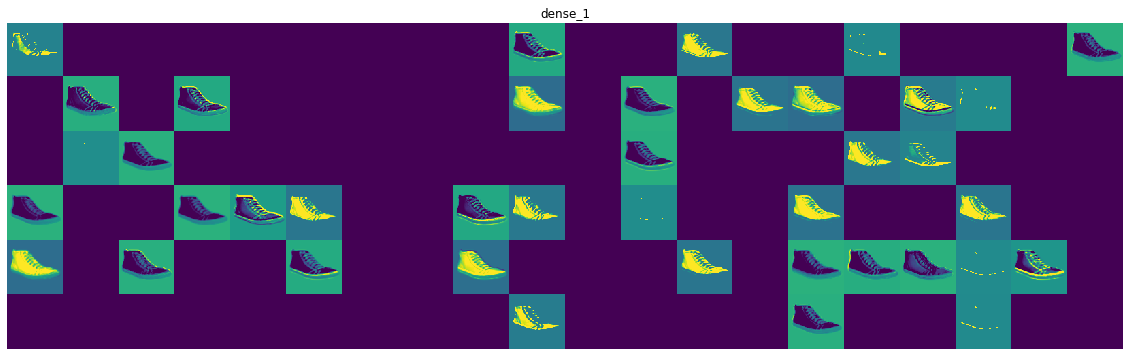

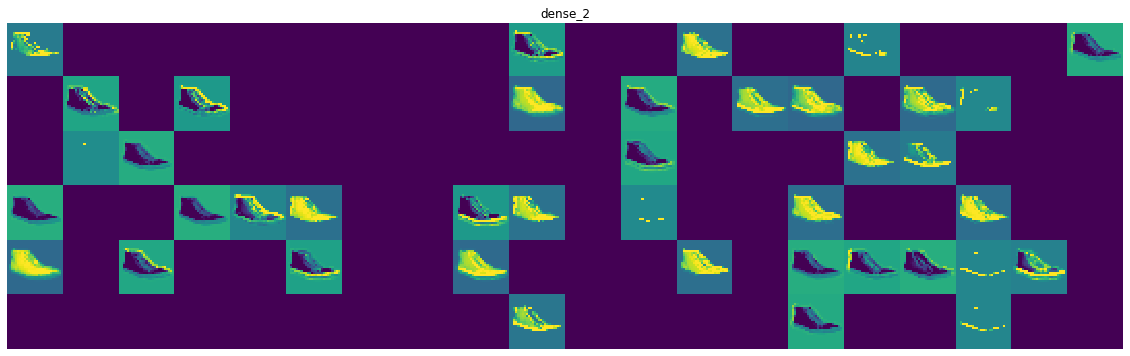

In [39]:
layer_names = []
for layer in model.layers[8:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 20

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.axis('off')
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

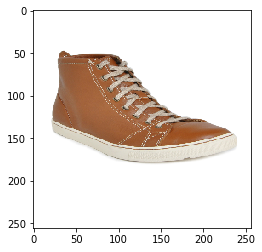

In [43]:
plt.imshow(np.clip(temp_arr[0], 0, 255).astype('uint8'))

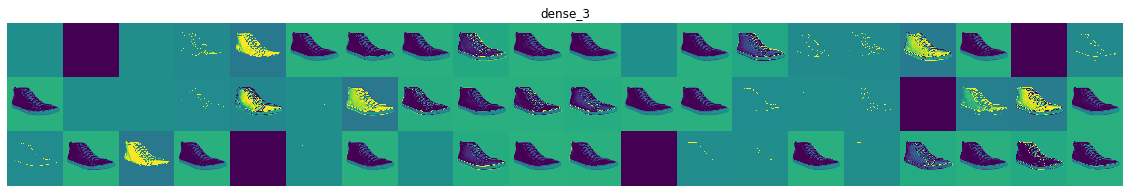

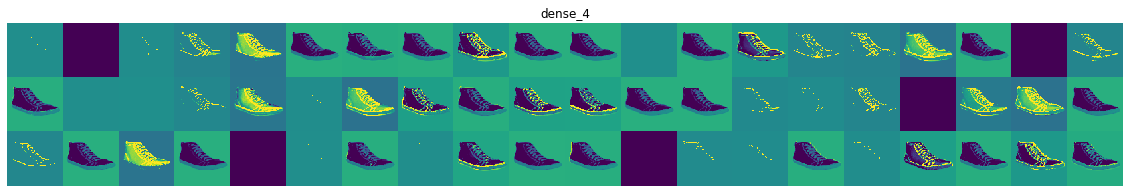

In [40]:
layer_names = []
for layer in model.layers[12:]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 20

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.axis('off')
    plt.imshow(display_grid, aspect='auto', cmap='viridis')